In [114]:
from my_weapon import *
from tqdm import tqdm_notebook as tqdm
from fake_identify import Are_you_IRA
import matplotlib
from collections import Counter

sns.set(style="darkgrid", font_scale=1.2)
ira_c = sns.color_palette("coolwarm", 8)[7]
all_c = sns.color_palette("coolwarm", 8)[0]

Putin = Are_you_IRA()

In [115]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [116]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend([
#     "rt", "…", "...", "URL", "http", "https", "“", "”", "‘", "’", "get", "2", "new", "one", "i'm", "make",
#     "go", "good", "say", "says", "know", "day", "..", "take", "got", "1", "going", "4", "3", "two", "n",
#     "like", "via", "u", "would", "still", "first", "really", "watch", "see", "even", "that's", "look", "way",
#     "last", "said", "let", "twitter", "ever", "always", "another", "many", "things", "may", "big", "come", "keep",
#     "5", "time", "much", "want", "think", "us", "love", "people", "need", "_"
# ])

stop_words.extend([
    "rt", "…", "...", "URL", "http", "https", "“", "”", "‘", "’", "get", "2", "new", "one", "i'm", "make",
    "go", "good", "say", "says", "know", "day", "..", "take", "got", "1", "going", "4", "3", "two", "n",
    "like", "via", "u", "would", "still", "first", "that's", "look", "way", "last", "said", "let",
    "twitter", "ever", "always", "another", "many", "things", "may", "big", "come", "keep",
    "5", "time", "much", "_", "cound", "-", '"'
])

stop_words.extend([',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%',
])

In [117]:
from Trump_Clinton_Classifer.TwProcess import CustomTweetTokenizer

tokenizer = CustomTweetTokenizer(preserve_case=False,
                                 reduce_len=True,
                                 strip_handles=False,
                                 normalize_usernames=False,
                                 normalize_urls=True,
                                 keep_allupper=False)

In [118]:
texts = []

data = pd.read_csv("data/ira-tweets-ele.csv", usecols=["tweet_text"])
for i, row in tqdm(data.iterrows()):
    # if row["userid"] not in users_comm:
    #     continue
    words = tokenizer.tokenize(row["tweet_text"])
    words = [w for w in words if w not in stop_words and w]
    # if words[0] == "RT":
    #     continue
#     for w in words:
#         cnt[w] += 1
    texts.append(words)
print(len(texts))
# json.dump(cnt.most_common(), open("data/word_cloud.json", "w"), indent=2)

391680


In [120]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# nlp = spacy.load('en')
import re

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    i = 0
    for sent in tqdm(texts):
        sent = " ".join(sent)
        sent = re.sub(r'#(\w+)', r'itstopiczzz\1', sent)
        sent = re.sub(r'@(\w+)', r'itsmentionzzz\1', sent)
        doc = nlp(sent)
        
        _d = [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in stop_words and token.lemma_]
#         _d = [(token.pos_, token.lemma_) for token in doc if token.lemma_ not in stop_words]
        
        _d = [x.replace('itstopiczzz', '#') for x in _d]
        _d = [x.replace('itsmentionzzz', '@') for x in _d]
        texts_out.append(_d)

    return texts_out

In [121]:
texts_out = lemmatization(texts)

In [122]:
len(texts_out)

391680

In [123]:
# save

with open("data/ira_texts.txt", "w") as f:
    for t in texts_out:
        f.write(" ".join(t) + "\n")

In [133]:
# load 

texts_out = []

with open("data/ira_texts.txt") as f:
    for line in f:
        w = [w for w in line.strip().split() if w != "" and w != "%"]
        if w:
            texts_out.append(w)

In [134]:
# Create Dictionary
id2word = corpora.Dictionary(texts_out)

# Create Corpus
texts = texts_out

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [112]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=7, chunksize=1000, random_state=43)

In [135]:
lda_model.print_topics()
# doc_lda = lda_model[corpus]

[(0,
  '0.016*"people" + 0.010*"white" + 0.009*"see" + 0.009*"@realdonaldtrump" + 0.008*"need" + 0.008*"think" + 0.007*"@danageezus" + 0.007*"work" + 0.006*"game" + 0.006*"house"'),
 (1,
  '0.040*"#new" + 0.020*"#world" + 0.008*"death" + 0.007*"#foke" + 0.007*"foke" + 0.006*"force" + 0.006*"#myolympicsportwouldbe" + 0.006*"kill" + 0.006*"#rejecteddebatetopic" + 0.005*"top"'),
 (2,
  '0.012*"kill" + 0.010*"cop" + 0.009*"old" + 0.009*"black" + 0.009*"@midnight" + 0.008*"people" + 0.008*"@gloed_up" + 0.007*"#blacklivesmatter" + 0.006*"play" + 0.006*"gun"'),
 (3,
  '0.013*"#sport" + 0.008*"#topnew" + 0.007*"#politic" + 0.006*"attack" + 0.006*"#tech" + 0.006*"high" + 0.006*"win" + 0.006*"post" + 0.006*"😂" + 0.005*"#obamaswishlist"'),
 (4,
  '0.009*"@giselleevns" + 0.007*"️" + 0.007*"name" + 0.006*"@chrixmorgan" + 0.006*"send" + 0.006*"#betteralternativetodebate" + 0.006*"become" + 0.006*"child" + 0.006*"nothing" + 0.006*"music"'),
 (5,
  '0.041*"trump" + 0.026*"hillary" + 0.022*"clinton" + 

In [136]:
# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -9.721526371366693







Coherence Score:  0.36374552447924585


In [141]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/alex/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [139]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.127210 -0.081916       1        1  17.529217
0     -0.163206 -0.051904       2        1  15.643783
6     -0.028462 -0.097684       3        1  14.949496
2     -0.142017  0.071139       4        1  13.703450
3      0.154796 -0.253563       5        1  13.354820
1      0.336585  0.109791       6        1  12.468131
4     -0.030487  0.304138       7        1  12.351110, topic_info=     Category          Freq                           Term         Total  \
131   Default  20829.000000                          trump  20829.000000   
217   Default  14128.000000                           #new  14128.000000   
113   Default  13103.000000                        hillary  13103.000000   
106   Default  11204.000000                        clinton  11204.000000   
90    Default  10705.000000                            man  10705.000000   
218   Default   7288.000000                         #world   7288.000000   
17    Default   9337.000000                         police   9337.000000   
87    Default   6130.000000                           vote   6130.000000   
488   Default   7433.000000                          woman   7433.000000   
286   Default  11612.000000                          black  11612.000000   
56    Default  13393.000000                         people  13393.000000   
672   Default   6242.000000                         #sport   6242.000000   
232   Default   6891.000000                           kill   6891.000000   
728   Default   4289.000000                          shoot   4289.000000   
529   Default   5629.000000                          white   5629.000000   
1589  Default   3816.000000                            cop   3816.000000   
144   Default   3964.000000               @realdonaldtrump   3964.000000   
179   Default   3807.000000                           live   3807.000000   
317   Default   3569.000000                            old   3569.000000   
859   Default   4003.000000                         donald   4003.000000   
33    Default   5288.000000                           life   5288.000000   
64    Default   3926.000000                          great   3926.000000   
1354  Default   3338.000000                      @midnight   3338.000000   
602   Default   3152.000000                   @giselleevns   3152.000000   
1306  Default   5204.000000                       #politic   5204.000000   
228   Default   2943.000000                        #topnew   2943.000000   
1395  Default   2944.000000                      @gloed_up   2944.000000   
410   Default   2763.000000                          death   2763.000000   
2556  Default   3094.000000                    @danageezus   3094.000000   
248   Default   6622.000000                           year   6622.000000   
...       ...           ...                            ...           ...   
1143   Topic7   2058.410400                         become   2059.234131   
2131   Topic7   1974.270752                        nothing   1975.094482   
1418   Topic7   1963.521240                          music   1964.344482   
646    Topic7   1895.006226                          group   1895.831055   
988    Topic7   1868.122559  #thingsmoretrustedthanhillary   1868.945190   
1482   Topic7   1845.159668                          young   1845.983765   
2372   Topic7   1722.479126                  #obamanextjob   1723.301514   
649    Topic7   1663.939697                         murder   1664.763794   
2706   Topic7   1654.478638       #myemmynominationwouldbe   1655.301392   
236    Topic7   1580.348389                          happy   1581.171387   
1858   Topic7   1555.122437                        suspect   1555.946533   
601    Topic7   1575.343994          #sextingwentwrongwhen   1576.183716   
2842   Topic7   1382.545410                         speech   1383.369873   
576    Topic7   1362.269897                        

In [74]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        # model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=41, step=1)

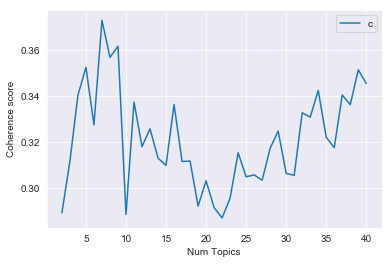

In [61]:
# Show graph
limit=41; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

In [55]:
lda_rst = {}

for line in open("lda_rst.txt"):
    '''
    Num Topics = 20  has Coherence Value of 0.3005
    '''
    if not line.startswith("Num"):
        continue
    w = line.strip().split()
    N = int(w[3]); score = float(w[-1])
    if N not in lda_rst:
        lda_rst[N] = []
    lda_rst[N].append(score)
# print(lda_rst)

In [56]:
new_lda_rst = []
for N, scores in lda_rst.items():
    for s in scores:
        new_lda_rst.append({"N": N, "Coherence": s})

In [57]:
new_lda_rst = pd.DataFrame(new_lda_rst)

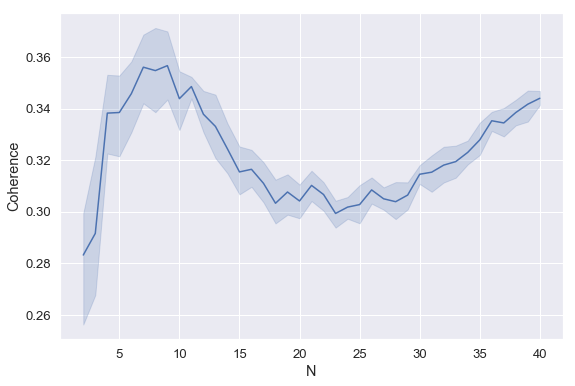

In [59]:
plt.figure(figsize=(9, 6))
sns.lineplot(x="N", y="Coherence", data=new_lda_rst)

最好的N（话题数）已经找到为7.

# 下面要找到最好的模型

78号模型 coherence = 0.364

In [127]:
lda_cohen = []

for line in open("lda_loglog.txt"):
    if line.startswith("Coherence Score: "):
        lda_cohen.append(float(line.strip().split()[-1]))

In [128]:
max(lda_cohen)

0.36374552447924585

In [140]:
from gensim.models import CoherenceModel, LdaModel

lda_model = LdaModel.load("model/lda-ira-78.mod")